# creazione dataset 

In [18]:
library(dplyr)
library(readr)
library(lubridate)
library(purrr)
library(tools)
library(ggplot2)
library(gridExtra)
library(stats)
library(R2jags)
library(coda)

In [43]:

create_dataset <- function(Monthly=FALSE,Yearly=FALSE) {
      
      data_folder <- "./data/daily"
    
      # Ottenere la lista di tutti i file con estensione .csv
      file_csv <- list.files(path = data_folder, pattern = "*.csv", full.names = TRUE)    
      # Creare un dataframe combinando i dati dai file CSV
      df <- file_csv |>
            map_df(~ read_csv(.x, show_col_types = FALSE) |>
            na.omit() |>
            mutate(file = file_path_sans_ext(basename(.x)),
                   month = ym(format(date, "%Y-%m")),
                   year_only = year(date))) |>
            filter(date >= as.Date('1993-01-01') & date <= as.Date('2021-12-31')) |>
            relocate( month, year_only, file, .after = date) |>
            arrange(date)     
            
      # Aggiungere colonne year e month_only
      df <- df |>
            mutate(month_only = as.double(format(month, "%m"))) |>
            relocate(month_only, .after = year_only)

      # dataset con summary mensii
      if(Monthly){
            df <- df |> group_by(month) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX)) |> 
                  mutate(year_only = as.double(format(month, "%Y")), month_only = as.double(format(month, "%m")))|>
            relocate(month_only, year_only, .after = month)
      }
      # dataset con summary annuali 
      if(Yearly){
            df <- df |> group_by(year_only) |> summarise(MIN_mean = mean(TMIN), MED_mean = mean(TMED), MAX_mean = mean(TMAX))
      }

    return(df)
}

# funzione per analizzare singoli mesi 
month_analisis <- function(df, n){
      m_df <- df[df$month_only == n,]
      return(m_df)
}

# heatmap che analizza evoluzione temperature su base mensile 
create_heatmap <- function(df, str){
    time_interval =1              # mesi finestra temporale precedente su cui fare la media
    years <- unique(df$year_only)   
    num_years <- length(years)
    heatmap_data <- data.frame()
    
    for (n in 1:12) {
        month_evolution <- month_analisis(df, n)      # estraiamo una summary dei mesi 
        if(str == 'min'){
            month_temp <- month_evolution$MIN_mean     # estraiamo solo la temperatura     
        }  
        else if(str == 'max'){
            month_temp <- month_evolution$MAX_mean     
        }    
        else(str == 'ava')
            month_temp <- month_evolution$MED_mean 
        
        diff <- c()
        
        for (t in (time_interval+1):length(month_temp)) {         # computiamo la differenza tra temperatura di un anno e la media dei 10 anni precedenti
            t_mean <- mean(month_temp[(t-time_interval):(t-1)])
            diff_i <- month_temp[t] - t_mean
            diff <- c(diff, diff_i)
        }
        
        temp_df <- data.frame(                        # costruiamo la heatmap 
            Month = rep(n, length(diff)),
            Year = month_evolution$year_only[(time_interval+1):length(month_temp)],
            Difference = diff
        )
        heatmap_data <- rbind(heatmap_data, temp_df)
    }
    
    # plot 
    heatmap_plot <- ggplot(heatmap_data, aes(x = Year, y = Month, fill = Difference)) +
        geom_tile() +
        scale_fill_gradient2(low = "navy", mid = "white", high = "orange", midpoint = 0) +
        labs(title = "Monthly Temperature difference w.r.t. 10 years before",
             x = "Year",
             y = "Month",
             fill = "Difference") +
        theme_bw()


    return(list(heatmap_plot, heatmap_data))
}


In [44]:
daily_dataset <- create_dataset()
monthly_dataset <- create_dataset(Monthly =   TRUE) 
yearly_dataset <- create_dataset(Yearly = TRUE)

head(monthly_dataset, 5)
tail(yearly_dataset, 5)

month,month_only,year_only,MIN_mean,MED_mean,MAX_mean
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1993-01-01,1,1993,-2.0817204,1.297359,5.577957
1993-02-01,2,1993,-3.2038446,2.299787,9.106274
1993-03-01,3,1993,0.7231183,5.937517,11.696237
1993-04-01,4,1993,6.0838889,11.371518,16.850000
1993-05-01,5,1993,11.4924731,17.757576,24.122043


year_only,MIN_mean,MED_mean,MAX_mean
<dbl>,<dbl>,<dbl>,<dbl>
2017,7.819840,12.73560,18.19665
2018,8.999717,13.47280,18.56399
2019,8.644268,13.26325,18.47706
2020,8.200003,13.01392,18.38279
2021,7.624164,12.48882,17.82049


# Part 0
## prima visualizzazione / analisi 


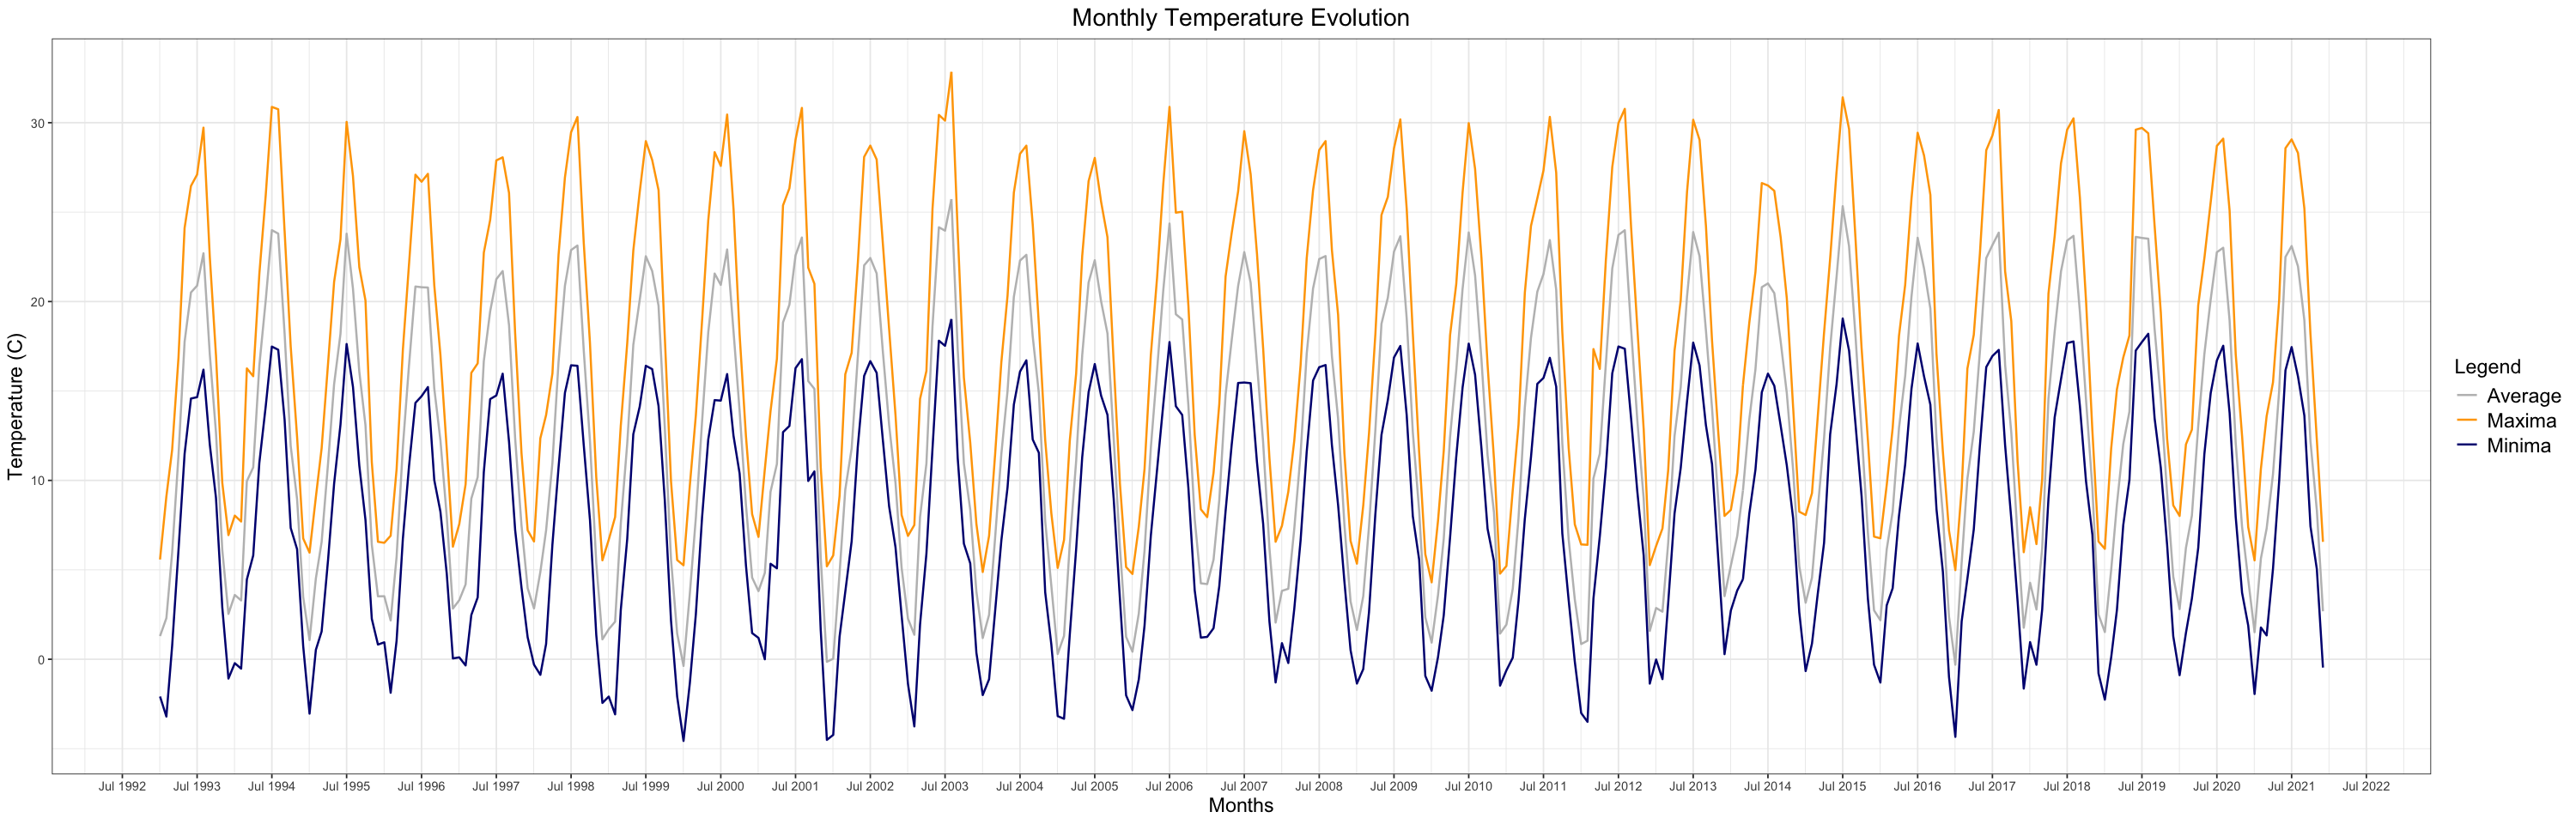

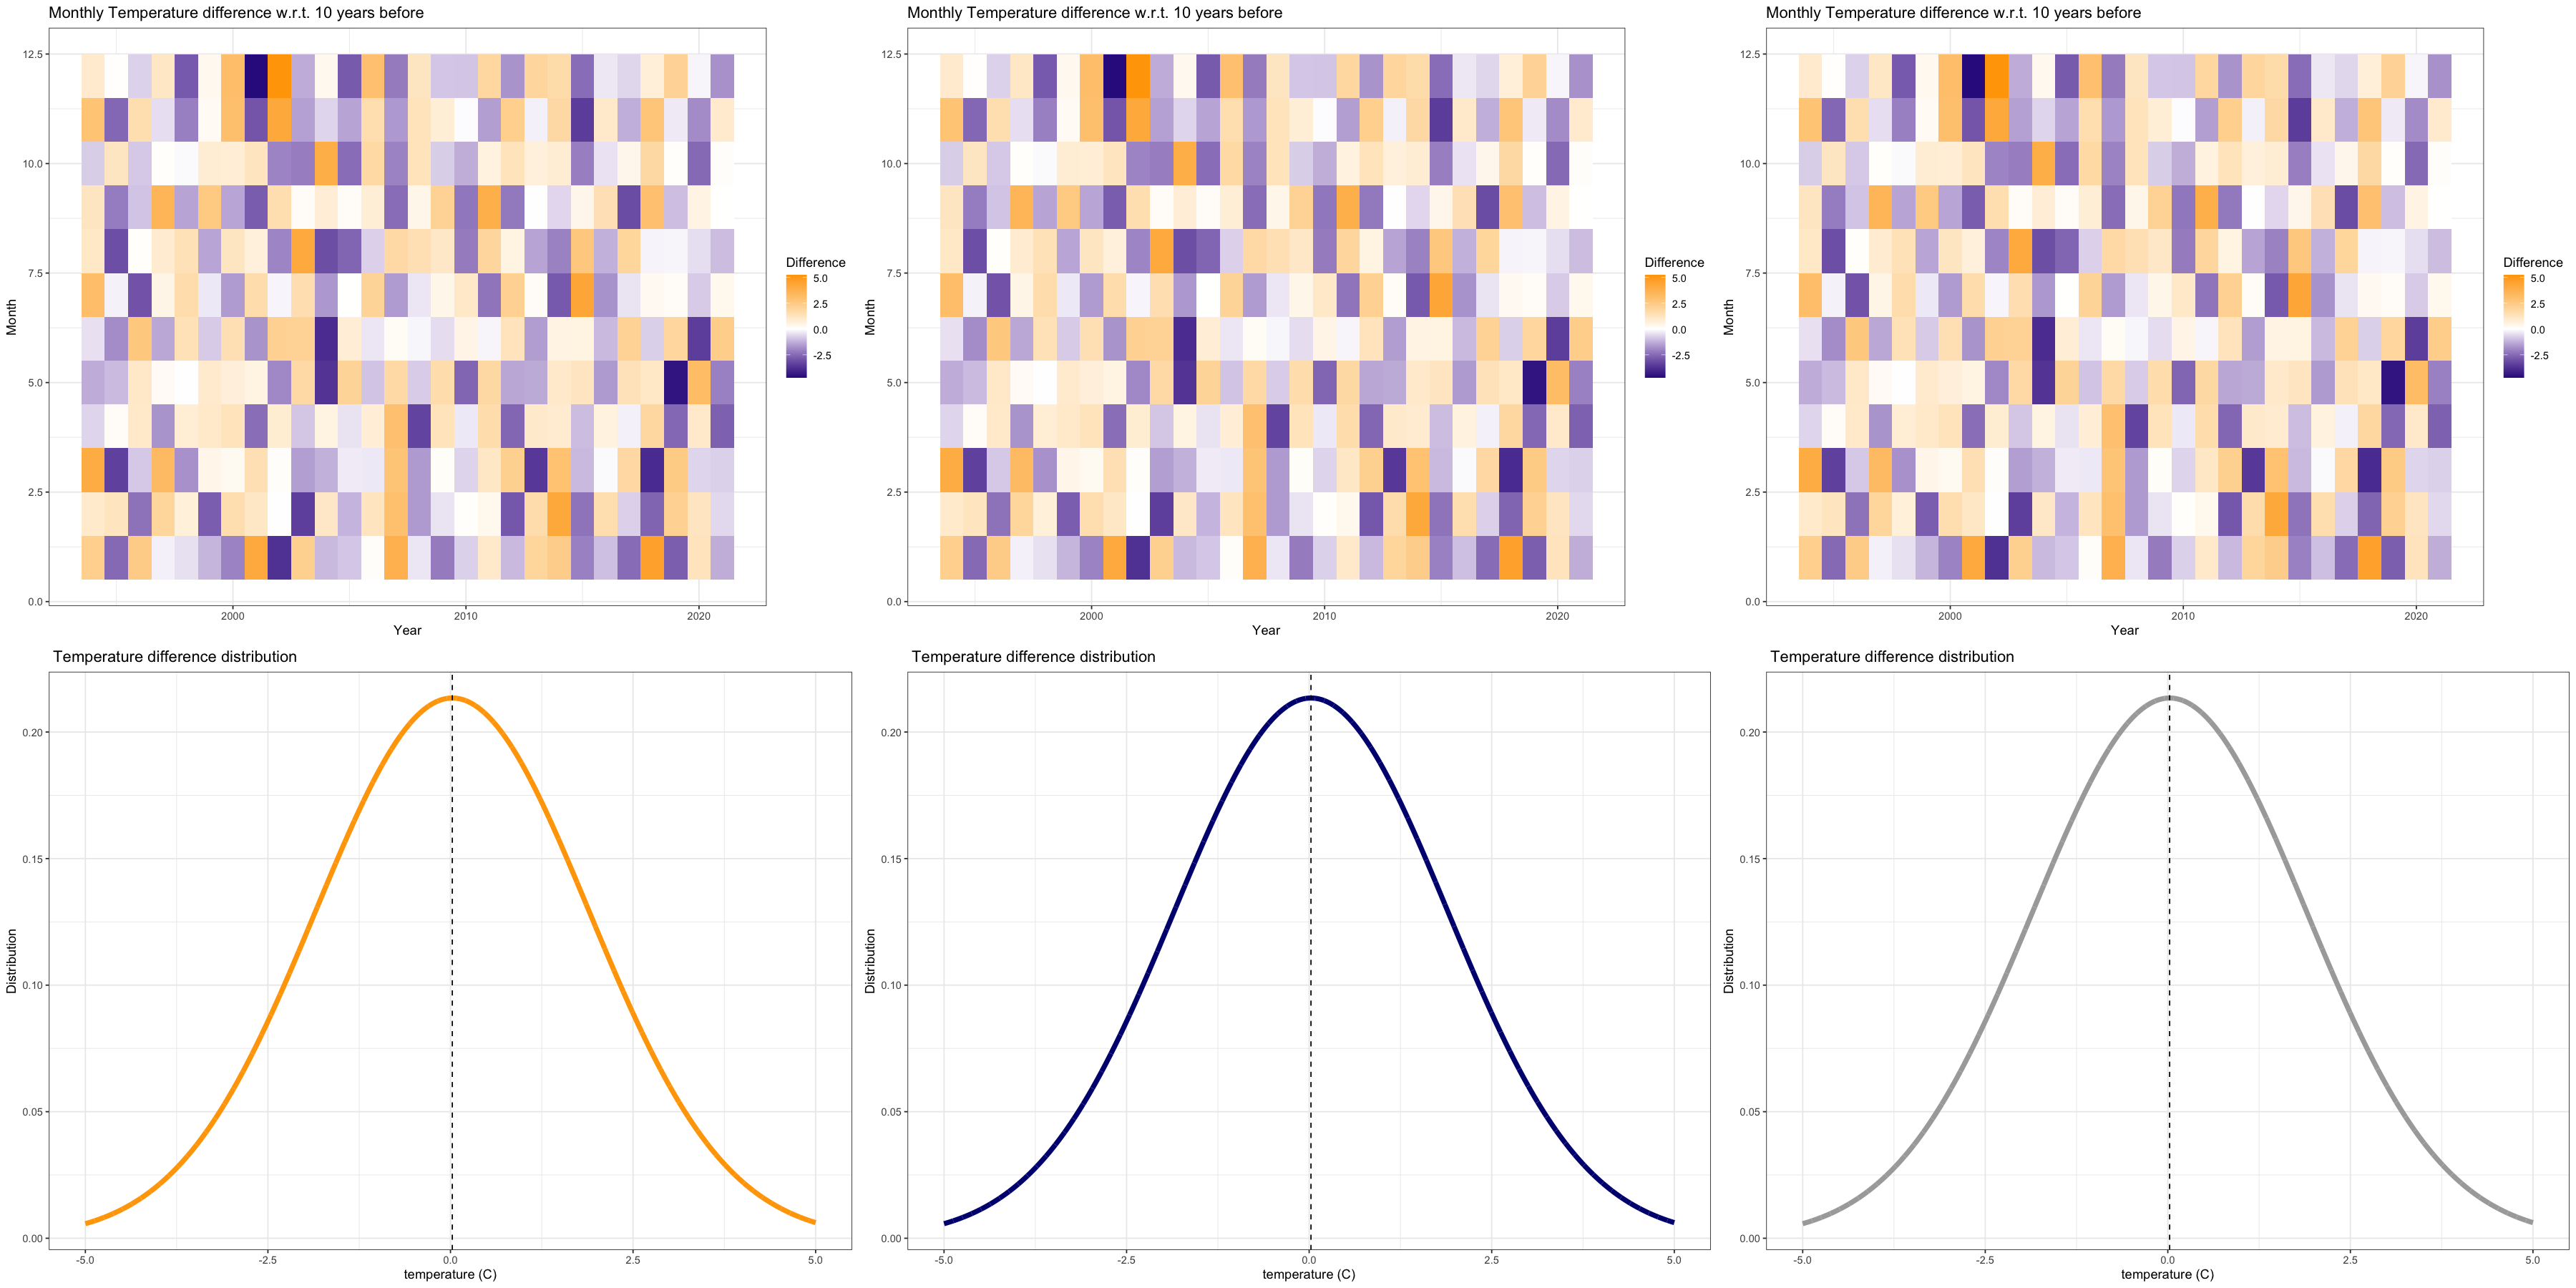

In [45]:
# Imposta la larghezza e l'altezza del plot
options(repr.plot.width = 25, repr.plot.height = 8)

# Grafico mensile
p_m <- ggplot(data = monthly_dataset) +
  geom_line(aes(x = month, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_line(aes(x = month, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Monthly Temperature Evolution',
       x = 'Months',
       y = 'Temperature (C)') +
  scale_x_date(date_breaks = "12 month", date_labels = "%b %Y") +
  theme_bw() +
  theme(plot.title = element_text(size = 17, hjust = 0.5),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14))

# Visualizza il grafico mensile
print(p_m)

h_max <- create_heatmap(df = monthly_dataset, str = 'max')
h_max_mean <- mean(h_max[[2]]$Difference)
h_max_var <- var(h_max[[2]]$Difference)
h_min <- create_heatmap(df = monthly_dataset, str = 'min')
h_min_mean <- mean(h_min[[2]]$Difference)
h_min_var <- var(h_min[[2]]$Difference)
h_ava <- create_heatmap(df = monthly_dataset, str = 'ava')
h_ava_mean <- mean(h_ava[[2]]$Difference)
h_ava_var <- var(h_ava[[2]]$Difference)

x_axis = seq(-5,5,0.001)

max_dist = dnorm(x=x_axis,sd = sqrt(h_max_var), mean = h_max_mean)
min_dist = dnorm(x=x_axis,sd = sqrt(h_min_var), mean = h_min_mean)
ava_dist = dnorm(x=x_axis,sd = sqrt(h_ava_var), mean = h_ava_mean)
df_max <- data.frame(x = x_axis, y = max_dist)
df_min <- data.frame(x = x_axis, y = min_dist)
df_ava <- data.frame(x = x_axis, y = ava_dist)


plot_max <- ggplot(df_max, aes(x = x, y = y)) + 
  geom_line(color = 'orange', linewidth = 2) + 
  geom_vline(aes(xintercept = h_max_mean), linetype = 2) +
  theme_bw()+
  labs(title = ' Temperature difference distribution ',
       x = 'temperature (C)',
       y = 'Distribution') 

plot_min <- ggplot(df_min, aes(x = x, y = y)) + 
  geom_line(color = 'navy', linewidth = 2) + 
  geom_vline(aes(xintercept = h_min_mean), linetype = 2) +
  theme_bw()+
  labs(title = ' Temperature difference distribution ',
       x = 'temperature (C)',
       y = 'Distribution') 

plot_ava <- ggplot(df_ava, aes(x = x, y = y)) + 
  geom_line(color = 'darkgray', linewidth = 2) + 
  geom_vline(aes(xintercept = h_ava_mean), linetype = 2) +
  theme_bw()+
  labs(title = ' Temperature difference distribution ',
       x = 'temperature (C)',
       y = 'Distribution') 

options(repr.plot.width = 30, repr.plot.height = 15)
grid.arrange(h_max[[1]], h_min[[1]], h_ava[[1]], 
             plot_max, plot_min, plot_ava, 
             ncol = 3, nrow = 2)





# Part 1

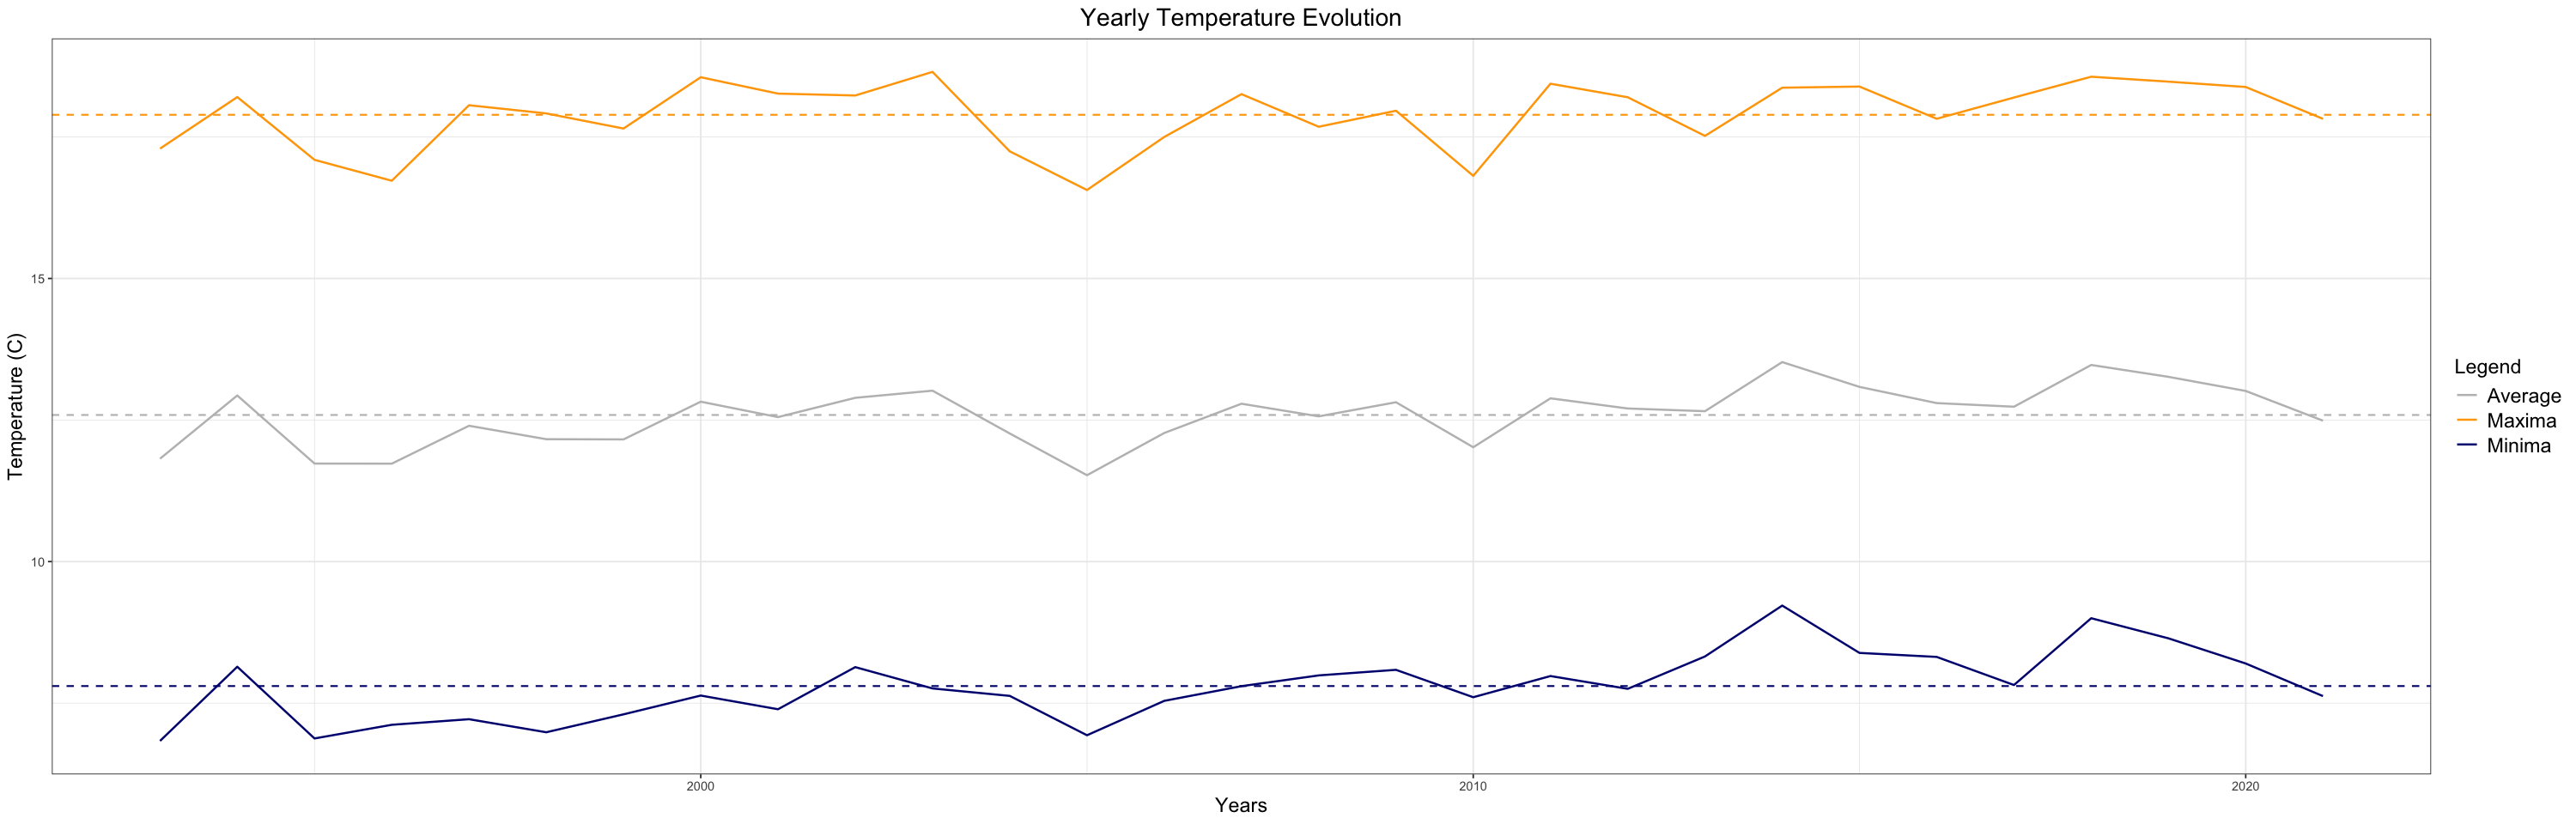

In [46]:
options(repr.plot.width = 25, repr.plot.height = 8)
# Grafico annuale
p_y <- ggplot(data = yearly_dataset) +
  geom_line(aes(x = year_only, y = MED_mean, color = 'Average'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MED_mean)), color = 'gray', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MIN_mean, color = 'Minima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MIN_mean)), color = 'navy', linewidth = 0.6, linetype = 2)+
  geom_line(aes(x = year_only, y = MAX_mean, color = 'Maxima'), group = 1, linewidth = 0.7) +
  geom_hline(aes(yintercept= mean(MAX_mean)), color = 'orange', linewidth = 0.6, linetype = 2)+  
  scale_color_manual(name = 'Legend', values = c('Minima' = 'navy', 'Maxima' = 'orange', 'Average' = 'gray')) +
  labs(title = 'Yearly Temperature Evolution',
       x = 'Years',
       y = 'Temperature (C)') +
  theme_bw() +
  theme(plot.title = element_text(size = 17, hjust = 0.5),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14))

# Visualizza il grafico annuale
print(p_y)

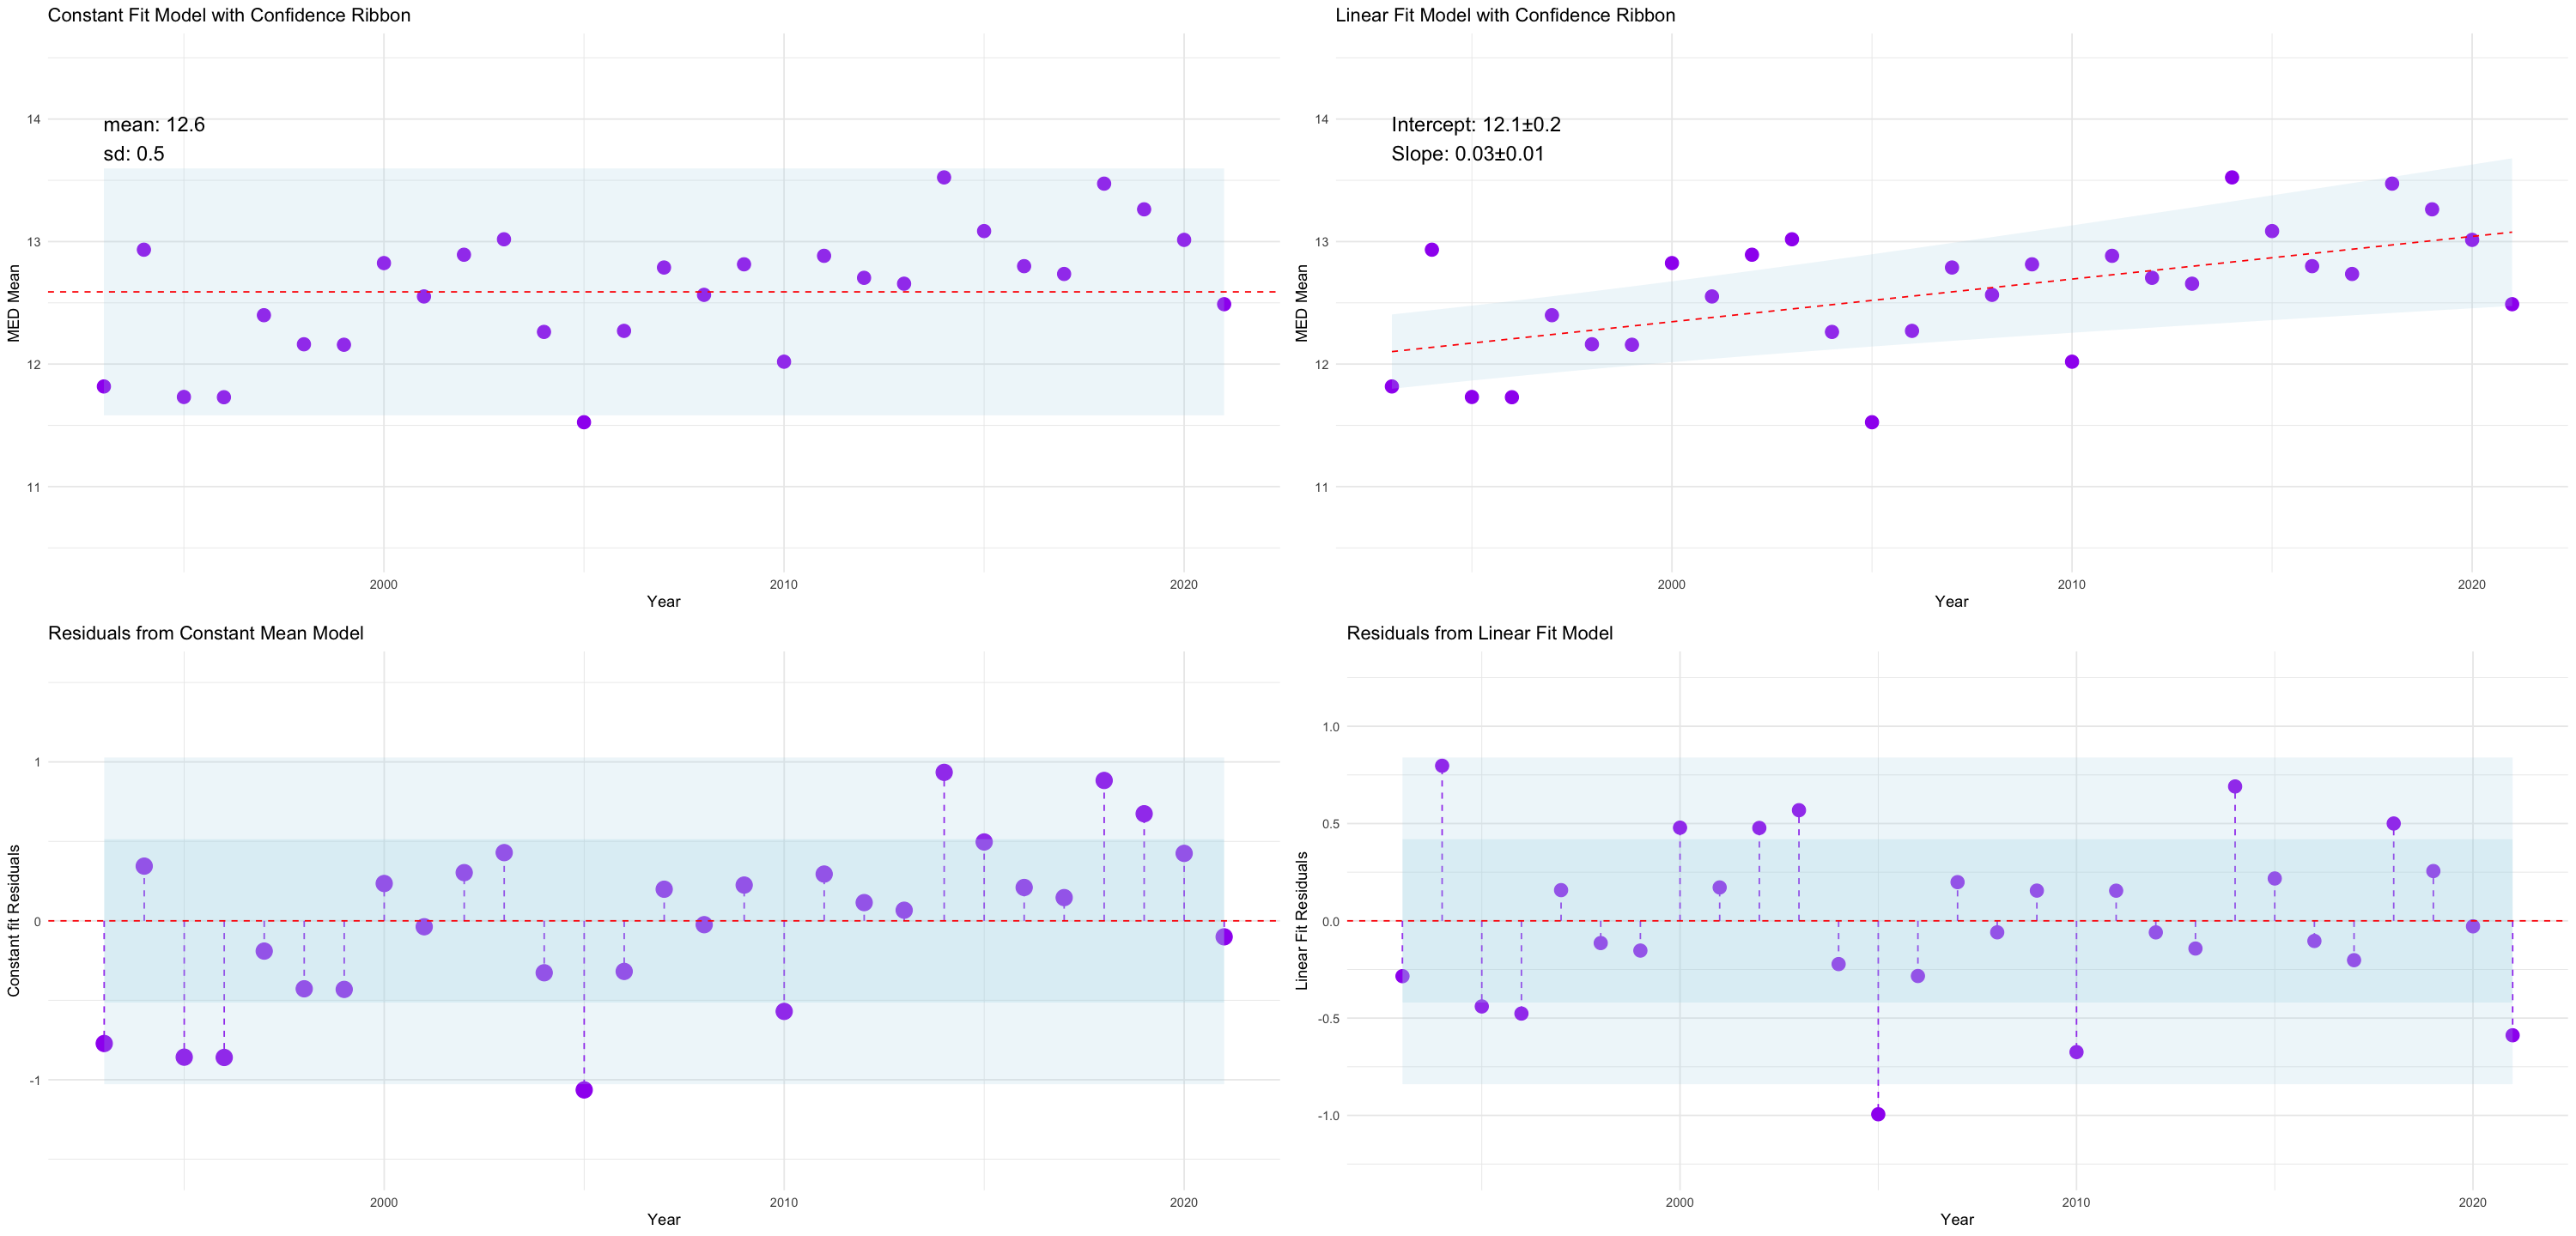

In [47]:
# Calcola x_fit sottraendo 1993 dall'anno
yearly_dataset$x_fit <- yearly_dataset$year_only - 1993

# Crea il modello lineare
model <- lm(MED_mean ~ x_fit, data = yearly_dataset)
model_summary <- summary(model)
model_coeff_err <- coef(model_summary)[, "Std. Error"]
model_coeff <- coef(model_summary)[, 'Estimate']

# Crea un dataframe con l'anno, MED_mean, i residui del modello, i residui costanti e i fitted values
fit_dataframe <- yearly_dataset %>%
  select(year_only, MED_mean) %>%
  mutate(linear_residuals = model$residuals) %>%
  mutate(const_residuals = MED_mean - mean(MED_mean)) %>%
  mutate(fitted_linear = model$fitted.values)

# Aggiungi gli intervalli di confidenza per i fitted values
fit_dataframe <- fit_dataframe %>%
  mutate(conf_lower = fitted_linear - 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2),
         conf_upper = fitted_linear + 1.96 * sqrt((model_coeff_err[2] * yearly_dataset$x_fit)^2 + (model_coeff_err[1])^2)) %>%
  mutate(x_fit = yearly_dataset$x_fit)

# Crea il testo per il grafico del fit costante
constant_fit_text <- paste0("mean: ", round(mean(yearly_dataset$MED_mean), 1), 
                            "\nsd: ", round(sqrt(var(yearly_dataset$MED_mean)), 1))

# Crea il grafico con la ribbon per il fit costante
p_a <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = mean(MED_mean) - 1.96*sqrt(var(MED_mean)), 
                  ymax = mean(MED_mean) + 1.96*sqrt(var(MED_mean))), 
              alpha = 0.2, fill = 'lightblue') +
  geom_hline(aes(yintercept = mean(MED_mean)), linetype = 2, color = 'red') +
  theme_minimal() +
  ylim(10.5, 14.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.5, 
           label = constant_fit_text, hjust = 0, vjust = 1, size = 5, color = 'black') +
  labs(title = "Constant Fit Model with Confidence Ribbon",
       x = "Year",
       y = "MED Mean")

# Crea il testo per il grafico del fit lineare
linear_fit_text <- paste0("Intercept: ", round(model_coeff[1], 1), '\u00B1', round(model_coeff_err[1], 1), 
                          "\nSlope: ", round(model_coeff[2], 2), '\u00B1', round(model_coeff_err[2], 2))

# Crea il grafico con la ribbon per il fit lineare
p_b <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = MED_mean), col = 'purple', size = 4) +
  geom_ribbon(aes(x = year_only, ymin = conf_lower, ymax = conf_upper), alpha = 0.2, fill = 'lightblue') +
  geom_line(aes(x = year_only, y = fitted_linear), linetype = 2, col = 'red') +
  theme_minimal() +
  ylim(10.5, 14.5) +
  annotate("text", x = min(fit_dataframe$year_only), y = max(fit_dataframe$MED_mean) + 0.5, 
           label = linear_fit_text, hjust = 0, vjust = 1, size = 5, color = "black") +
  labs(title = "Linear Fit Model with Confidence Ribbon",
       x = "Year",
       y = "MED Mean")

p_c <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = const_residuals), col = 'purple', size = 5) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = const_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(MED_mean)), ymax = 2*sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2*sqrt(var(MED_mean)), ymax = 3*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2*sqrt(var(MED_mean)), ymax = -sqrt(var(MED_mean))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3*sqrt(var(MED_mean)), ymax = -2*sqrt(var(MED_mean))), alpha = 0., fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Constant Mean Model",
       x = "Year",
       y = "Constant fit Residuals")

# Crea il grafico dei residui del fit lineare
p_d <- ggplot(data = fit_dataframe) +
  geom_point(aes(x = year_only, y = linear_residuals), col = 'purple', size = 4) +
  geom_segment(aes(x = year_only, xend = year_only, y = 0, yend = linear_residuals), linetype = 2, color = 'purple') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.4, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = sqrt(var(linear_residuals)), ymax = 2 * sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = 2 * sqrt(var(linear_residuals)), ymax = 3 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -2 * sqrt(var(linear_residuals)), ymax = -sqrt(var(linear_residuals))), alpha = 0.2, fill = 'lightblue') +
  geom_ribbon(aes(x = year_only, ymin = -3 * sqrt(var(linear_residuals)), ymax = -2 * sqrt(var(linear_residuals))), alpha = 0.0, fill = 'lightblue') +
  geom_hline(aes(yintercept = 0), linetype = 2, color = 'red') +
  theme_minimal() +
  labs(title = "Residuals from Linear Fit Model",
       x = "Year",
       y = "Linear Fit Residuals")

# Imposta le dimensioni del grafico
options(repr.plot.width = 25, repr.plot.height = 12)

# Visualizza i grafici
grid.arrange(p_a, p_b, p_c, p_d, 
             ncol = 2, nrow = 2)


In [48]:
# Funzione per inizializzare le variabili
init_variables <- function(model_name) {
    if (model_name == "lin_model") {
        return(function() list(a = runif(1, -20, 20), b = runif(1, -0.5, 0.5), sigma = runif(1, 0, 0.8)))
    } else if (model_name == "const_model") {
        return(function() list(a = runif(1, -20, 20), sigma = runif(1, 0, 0.8)))
    }
}

# Funzione per eseguire la regressione
regression <- function(df, model_file, params) {
    data <- df %>% select(x_fit, MED_mean)
    inits <- init_variables(gsub(".jags", "", model_file))
    jm <- jags.model(model_file, data, inits, n.chains = 1, n.adapt = 1000)
    update(jm, n.iter = 50000)
    chain <- coda.samples(jm, params, n.iter = 1e7, thin = 20)
    return(chain)
}

trace_plot <- function(chain, type) {
    chain_df <- as.data.frame( as.mcmc(chain) ) 
    chain_df$iteration <- seq.int(nrow(chain_df))
    
    if(type == 'linear'){
        
        plot_a <- ggplot(chain_df, aes(x = iteration, y = a)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of a"),
                x = "Iteration",
                y = 'a') +
            theme_minimal()

        plot_b <- ggplot(chain_df, aes(x = iteration, y = b)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of b"),
                x = "Iteration",
                y = 'b') +
            theme_minimal()
        
        plot_sigma <- ggplot(chain_df, aes(x = iteration, y = sigma)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of sigma"),
                x = "Iteration",
                y = 'sigma') +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)
        return(grid.arrange(plot_a, plot_b, plot_sigma,  ncol = 3, nrow = 1))
    }

    else if(type == 'constant'){
       
        plot_a <- ggplot(chain_df, aes(x = iteration, y = a)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of a"),
                x = "Iteration",
                y = 'a') +
            theme_minimal()

        
        plot_sigma <- ggplot(chain_df, aes(x = iteration, y = sigma)) +
            geom_line(alpha = 0.9, color = 'lightblue') +
            labs(title = paste("Trace Plot of sigma"),
                x = "Iteration",
                y = 'sigma') +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)
        return(grid.arrange(plot_a, plot_sigma,  ncol = 2, nrow = 1))
    }    
}

density_plot <- function(chain, type) {
    chain_df <- as.data.frame( as.mcmc(chain) ) 
    chain_df$iteration <- seq.int(nrow(chain_df))
    
    if(type == 'linear'){
        
        plot_a <- ggplot(chain_df, aes(x = a)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            labs(title = paste("Posterior Distribution of a"),
                x = 'a',
                y = "Density") +
            theme_minimal()

        plot_b <- ggplot(chain_df, aes(x = b)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            labs(title = paste("Posterior Distribution of b"),
                x = 'b',
                y = "Density") +
            theme_minimal()
        
        plot_sigma <- ggplot(chain_df, aes(x = sigma)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            labs(title = paste("Posterior Distribution of sigma"),
                x = 'sigma',
                y = "Density") +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)
        return(grid.arrange(plot_a, plot_b, plot_sigma,  ncol = 3, nrow = 1))
    }

    else if(type == 'constant'){
       
        plot_a <- ggplot(chain_df, aes(x = a)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            labs(title = paste("Posterior Distribution of a"),
                x = 'a',
                y = "Density") +
            theme_minimal()

        plot_sigma <- ggplot(chain_df, aes(x = sigma)) +
            geom_density(alpha = 0.5, fill = 'lightblue', color = 'navy') +
            labs(title = paste("Posterior Distribution of sigma"),
                x = 'sigma',
                y = "Density") +
            theme_minimal()
        options(repr.plot.width = 25, repr.plot.height = 7)
        return(grid.arrange(plot_a, plot_sigma,  ncol = 2, nrow = 1))
    }    
}


In [49]:
# Parametri per i modelli
lin_model_file <- "lin_model.jags"
lin_pars <- c("a", "b", "sigma")

const_model_file <- "const_model.jags"
const_pars <- c("a", "sigma")

# Esempio di esecuzione della regressione per il modello lineare
lin_chain <- regression(yearly_dataset, lin_model_file, lin_pars)

# Esempio di esecuzione della regressione per il modello costante
const_chain <- regression(yearly_dataset, const_model_file, const_pars)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 29
   Unobserved stochastic nodes: 3
   Total graph size: 128

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 29
   Unobserved stochastic nodes: 2
   Total graph size: 67

Initializing model



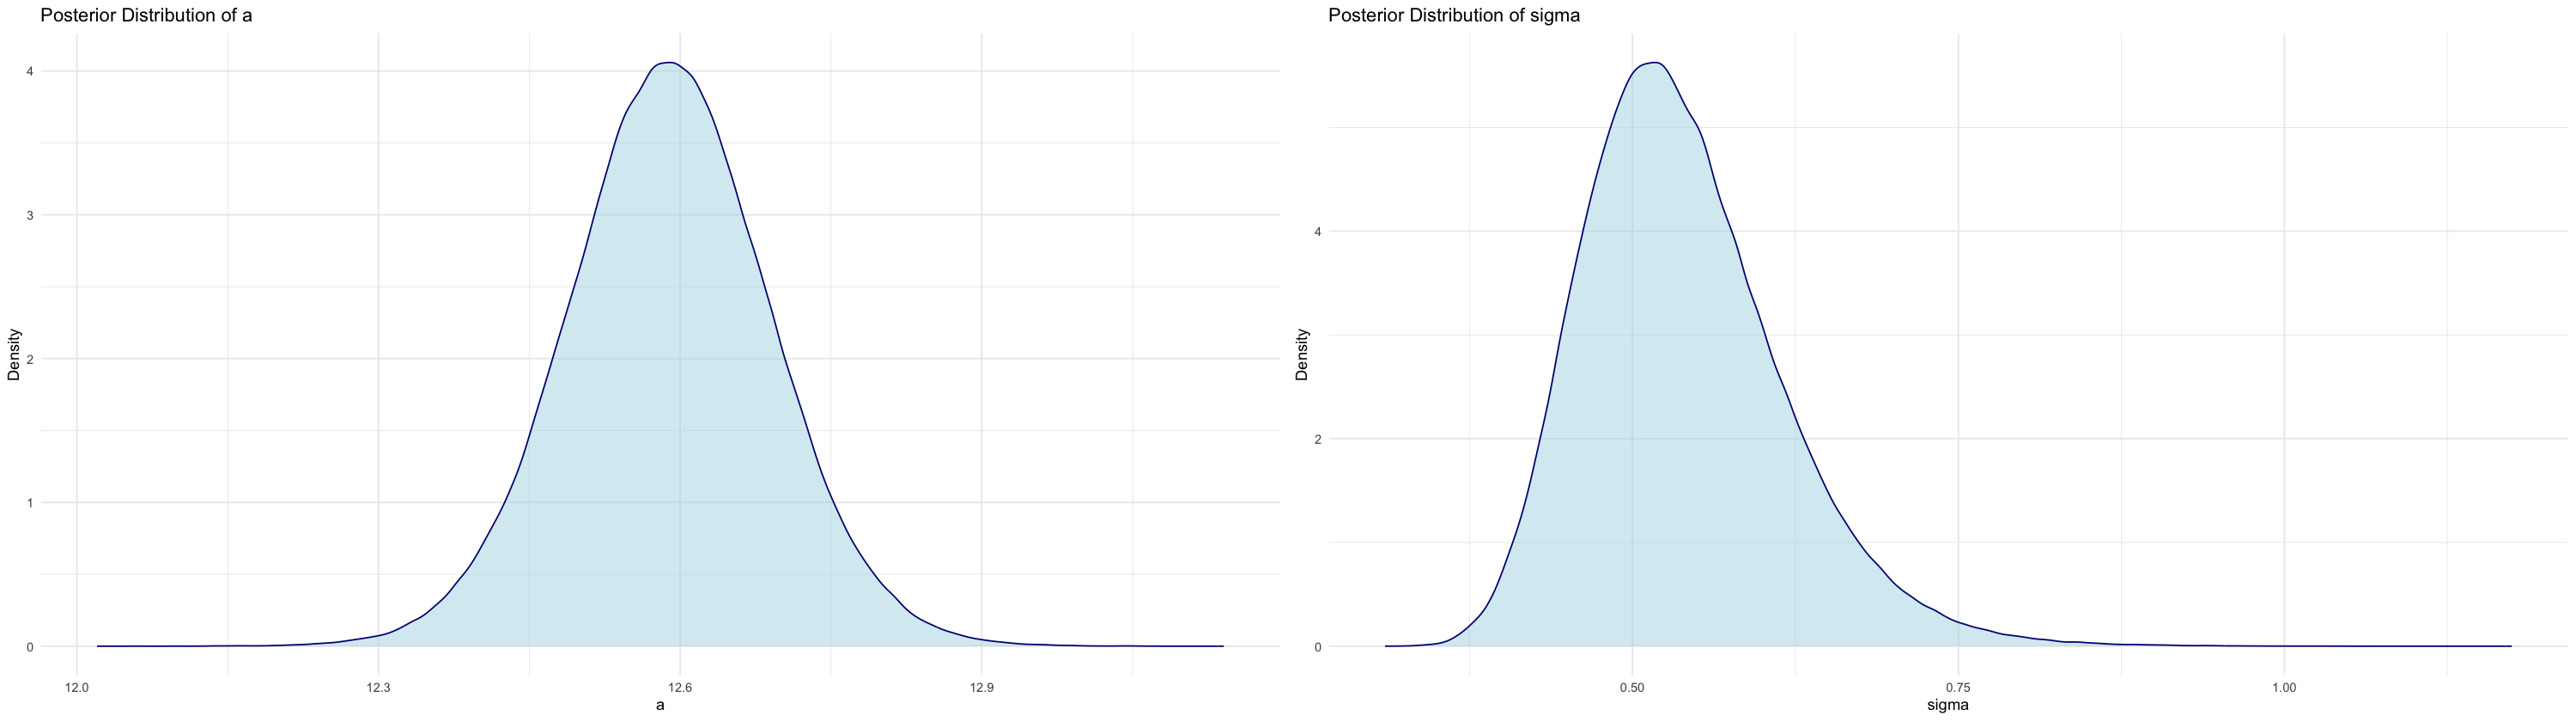

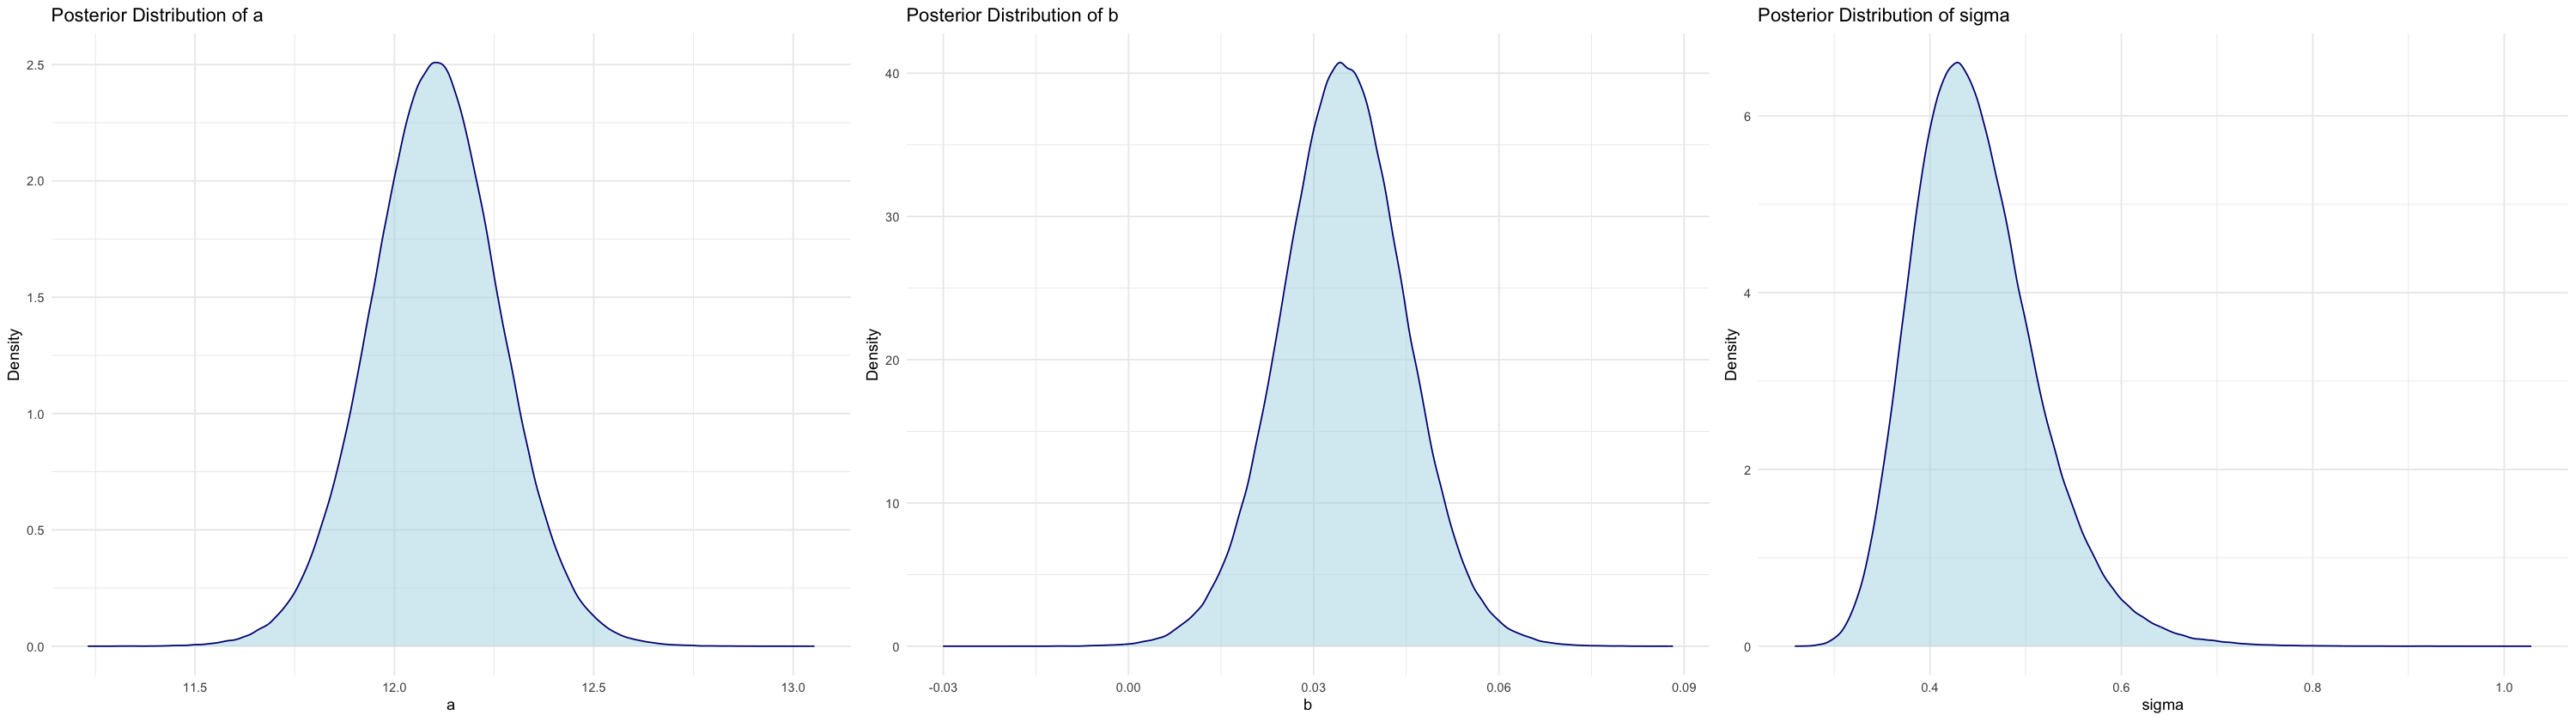

In [50]:
density_plot(const_chain, 'constant')
density_plot(lin_chain, 'linear')